In [ ]:
#/Users/veronicamorelli/anaconda3/envs/BigDataGIS/bin/python prova.py

# Exploring Global Mean Sea Level Pressure in the ERA of Climate Change

Climate change stands as one of the most critical challenges confronting our planet, exerting profound impacts on various facets of ecosystems and atmospheric conditions. Within this complex web of transformations, mean sea level pressure (MSLP) emerges as a pivotal variable, embodying crucial insights into climatic shifts. MSLP captures alterations in air pressure at sea level, offering a unique lens to observe atmospheric dynamics. Understanding the intricate patterns of MSLP is essential, as it directly influences regional and global weather systems, including wind patterns, storm formation, and precipitation distribution. Predicting MSLP changes is crucial for anticipating shifts in climate conditions, aiding in early preparedness for extreme weather events and contributing to a more comprehensive understanding of the Earth's climate dynamics.

This project delves into the analysis of long-term historical MSLP data alongside simulations from climate models. The primary goal is to discern patterns, trends, and anomalies in MSLP over a century, exploring the nuanced variations in pressure distributions and their implications for climate change.

In [2]:
# Import libraries
import json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
import warnings
# import cv2
# import xesmf as xe

import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import geopandas as gpd

# To make visualization better
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Set plot size
plt.rcParams['figure.figsize'] = [8, 4]

# To ignore all warnings
warnings.filterwarnings("ignore")

## Import

### ERA5 Mean Sea Level Pressure (MSLP) (1950-2020)

In [3]:
mslp1 = 'Dataset/era_single_level_mslp_part1.nc'
mslp1 = xr.open_dataset(mslp1)
mslp1

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 5479)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1990-01-01T12:00:00 ... 2004-12-31T12:00:00
Data variables:
    msl        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-29 21:26:01 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

### CMIP6 (2015-2050) - CESM2

In [47]:
path_cesm2 = 'Dataset/cmpi6/psl_Amon_CESM2_ssp126_r4i1p1f1_gn_20150115-20501215_v20200528.nc'
model = xr.open_dataset(path_cesm2)
model

<xarray.Dataset>
Dimensions:    (time: 432, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 2015-01-15 12:00:00 ... 2050-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    psl        (time, lat, lon) float32 ...
    time_bnds  (time, nbnd) object ...
    lat_bnds   (lat, nbnd) float64 ...
    lon_bnds   (lon, nbnd) float64 ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   735110.0
    branch_time_in_parent:  735110.0
    case_id:                1729
    ...                     ...
    sub_experiment_id:      none
    table_id:               Amon
    tracking_id:            hdl:21.14100/5aa6c2c5-f0ab-4317-87f1-58521102355f
    variable_id:            psl
    variant_info:           CMIP6 SSP1-2.6 experiments (2015-2100) with CAM6,...
    variant_label:          r4i1p1f1

From this output I notice that latitude and longitude refer to cells centroid but the longitude range is [0, 359]. I convert longitude coordinates to [-180, 179] range.

The reason for this adjustment is to bring the longitude values to a standard range that is more commonly used in geosciences and GIS applications.

In the original CESM2 dataset, the longitude values are provided in the [0, 359] range, where 0 represents the Prime Meridian, and the values increase to the east until reaching 359. This convention is sometimes used in climate models and meteorological data. However, it's more common in many geospatial applications to represent longitudes in the range [-180, 180], where negative values represent west of the Prime Meridian, and positive values represent east.

Converting longitudes to the [-180, 180] range makes it easier to work with the data, especially when combining datasets, mapping, or performing spatial analyses. It aligns with the standard used in many GIS tools and libraries.


In [48]:
# Change longitude definition from [0, 360] to [-180, 180] for best scenario
model.__setitem__('lon_bnds', ((model.lon_bnds + 180) % 360) - 180) # boundaries
model = model.assign_coords(lon=(((model.lon + 180) % 360) - 180)).sortby('lon') # coordinates
model = model.sortby('lat', ascending=False) # sort by lat
model

<xarray.Dataset>
Dimensions:    (time: 432, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 90.0 89.06 88.12 87.17 ... -88.12 -89.06 -90.0
  * lon        (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * time       (time) object 2015-01-15 12:00:00 ... 2050-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    psl        (time, lat, lon) float32 ...
    time_bnds  (time, nbnd) object ...
    lat_bnds   (lat, nbnd) float64 ...
    lon_bnds   (lon, nbnd) float64 179.4 -179.4 -179.4 ... 178.1 178.1 179.4
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   735110.0
    branch_time_in_parent:  735110.0
    case_id:                1729
    ...                     ...
    sub_experiment_id:      none
    table_id:               Amon
    tracking_id:            hdl:21.14100/5aa6c2c5-f0ab-4317-87f1-58521102355f
    variable_id:            psl
    variant_info:           CMIP6 SSP1-2.6 experiments (2015-2100) with CAM6,...
    variant_label:          r4i1p1f1

### Change Unit

To convert pressure from Pascals (Pa) to hectopascals (hPa), you can use the conversion factor \(1 \, \text{hPa} = 100 \, \text{Pa}\). The conversion is straightforward: divide the pressure value in Pascals by 100.

So, the conversion formula is:

$\text{Pressure (hPa)} = \frac{\text{Pressure (Pa)}}{100}$

For example, if you have a mean sea level pressure of 101500 Pa, the equivalent value in hPa would be:

$\text{Pressure (hPa)} = \frac{101500 \, \text{Pa}}{100} = 1015 \, \text{hPa}$

Simply divide the pressure value in Pascals by 100 to obtain the pressure value in hectopascals.


In [49]:
model['psl_hpa'] = model['psl'] / 100
# Update the variable attributes
model['psl_hpa'].attrs['units'] = 'hPa'

model

<xarray.Dataset>
Dimensions:    (time: 432, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 90.0 89.06 88.12 87.17 ... -88.12 -89.06 -90.0
  * lon        (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * time       (time) object 2015-01-15 12:00:00 ... 2050-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    psl        (time, lat, lon) float32 1.006e+05 1.006e+05 ... 9.959e+04
    time_bnds  (time, nbnd) object ...
    lat_bnds   (lat, nbnd) float64 ...
    lon_bnds   (lon, nbnd) float64 179.4 -179.4 -179.4 ... 178.1 178.1 179.4
    psl_hpa    (time, lat, lon) float32 1.006e+03 1.006e+03 ... 995.9 995.9
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   735110.0
    branch_time_in_parent:  735110.0
    case_id:                1729
    ...                     ...
    sub_experiment_id:      none
    table_id:               Amon
    tracking_id:            hdl:21.14100/5aa6c2c5-f0ab-4317-87f1-58521102355f
    variable_id:            psl
    variant_info:           CMIP6 SSP1-2.6 experiments (2015-2100) with CAM6,...
    variant_label:          r4i1p1f1

In [50]:
print("Dimensions and Sizes:")
print(model.dims)

print('---------------------------')

print("Coordinates:")
print(model.coords)

print('---------------------------')

print("Attributes:")
print(model.attrs)

print('---------------------------')

print(model.data_vars)

Dimensions and Sizes:
Frozen({'time': 432, 'lat': 192, 'lon': 288, 'nbnd': 2})
---------------------------
Coordinates:
Coordinates:
  * lat      (lat) float64 90.0 89.06 88.12 87.17 ... -87.17 -88.12 -89.06 -90.0
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * time     (time) object 2015-01-15 12:00:00 ... 2050-12-15 12:00:00
---------------------------
Attributes:
{'Conventions': 'CF-1.7 CMIP-6.2', 'activity_id': 'ScenarioMIP', 'branch_method': 'standard', 'branch_time_in_child': 735110.0, 'branch_time_in_parent': 735110.0, 'case_id': '1729', 'cesm_casename': 'b.e21.BSSP126cmip6.f09_g17.CMIP6-SSP1-2.6.103', 'contact': 'cesm_cmip6@ucar.edu', 'creation_date': '2020-05-26T19:55:22Z', 'data_specs_version': '01.00.31', 'experiment': 'SSP-based RCP scenario with low radiative forcing by the end of the century.  Following approximately RCP2.6 global forcing pathway with SSP1 socioeconomic conditions. Radiative forcing reaches a level of 2.6 W/m2 in 2100. Con

In [51]:
model.psl_hpa[0]

<xarray.DataArray 'psl_hpa' (lat: 192, lon: 288)>
array([[1006.151  , 1006.151  , 1006.151  , ..., 1006.151  , 1006.151  ,
        1006.151  ],
       [1007.6164 , 1007.6259 , 1007.6347 , ..., 1007.58234, 1007.5946 ,
        1007.606  ],
       [1008.795  , 1008.81   , 1008.82385, ..., 1008.7402 , 1008.75995,
        1008.7784 ],
       ...,
       [ 998.1641 ,  998.15564,  998.14795, ...,  998.19116,  998.1836 ,
         998.1733 ],
       [ 999.0705 ,  999.0672 ,  999.0643 , ...,  999.1074 ,  999.09143,
         999.07837],
       [ 999.9183 ,  999.91833,  999.91833, ...,  999.9176 ,  999.9176 ,
         999.9179 ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 90.0 89.06 88.12 87.17 ... -87.17 -88.12 -89.06 -90.0
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
    time     object 2015-01-15 12:00:00
Attributes:
    units:    hPa

In [52]:
print(model.psl_hpa.coords)

Coordinates:
  * lat      (lat) float64 90.0 89.06 88.12 87.17 ... -87.17 -88.12 -89.06 -90.0
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * time     (time) object 2015-01-15 12:00:00 ... 2050-12-15 12:00:00


In [53]:
model.psl_hpa[0].coords

Coordinates:
  * lat      (lat) float64 90.0 89.06 88.12 87.17 ... -87.17 -88.12 -89.06 -90.0
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
    time     object 2015-01-15 12:00:00

In [56]:
model.psl_hpa[0].coords['time']

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(2015, 1, 15, 12, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 2015-01-15 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time
    title:          time
    type:           double

## Visualizations

### ERA5 Mean Sea Level Pressure (MSLP) (1950-2020)

### CMIP6 (2015-2050) - CESM2

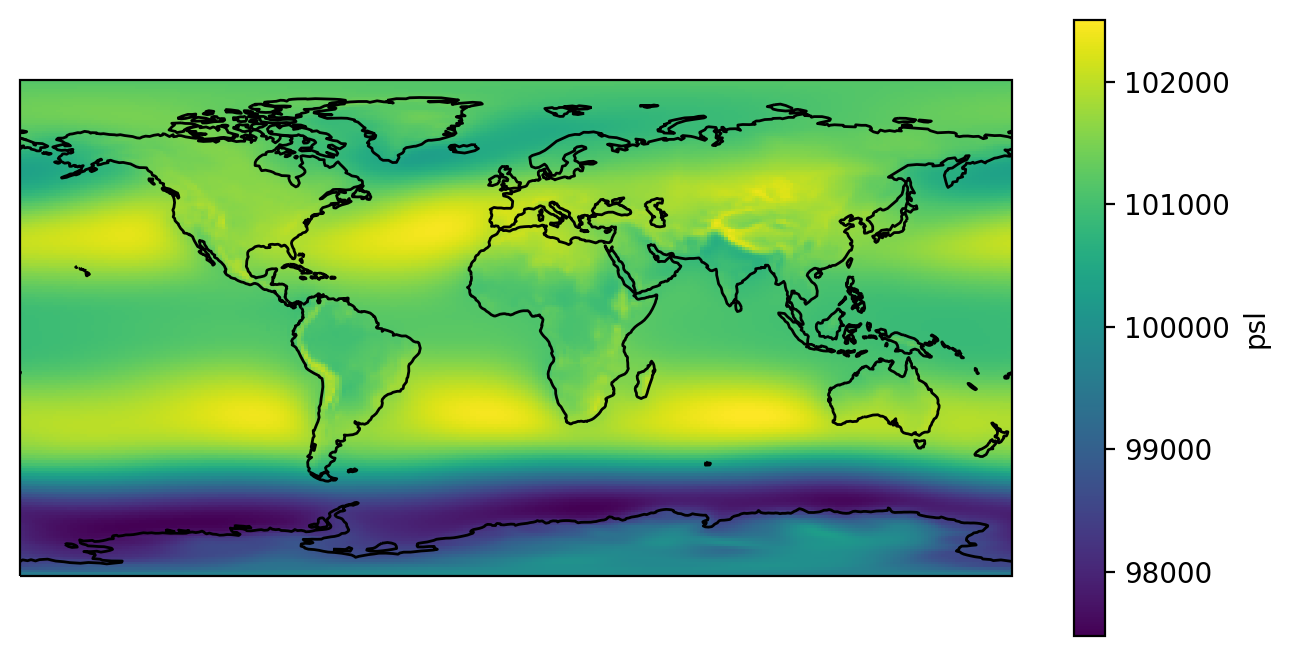

In [26]:
# Plot the mean values of scenario over time
p = model.psl.mean(dim='time').plot(subplot_kws={'projection': ccrs.PlateCarree()})
p.axes.coastlines()

In [59]:
model.psl.mean(dim='time')

<xarray.DataArray 'psl' (lat: 192, lon: 288)>
array([[101164.36 , 101164.36 , 101164.36 , ..., 101164.36 , 101164.36 ,
        101164.36 ],
       [101183.84 , 101184.16 , 101184.43 , ..., 101182.93 , 101183.2  ,
        101183.51 ],
       [101210.26 , 101211.04 , 101211.8  , ..., 101207.59 , 101208.55 ,
        101209.37 ],
       ...,
       [ 99189.516,  99182.32 ,  99173.305, ...,  99211.35 ,  99203.914,
         99196.695],
       [ 99550.3  ,  99549.53 ,  99549.16 , ...,  99553.984,  99552.516,
         99551.234],
       [ 99823.305,  99823.336,  99823.336, ...,  99823.19 ,  99823.19 ,
         99823.24 ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 90.0 89.06 88.12 87.17 ... -87.17 -88.12 -89.06 -90.0
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8

In [67]:
lat = model.psl_hpa.coords['lat'].values
lon = model.psl_hpa.coords['lon'].values
model_psl_hpa_mean = model.psl_hpa.mean(dim='time')

In [68]:
psl_mean = pd.DataFrame(model_psl_hpa_mean, lat, lon)

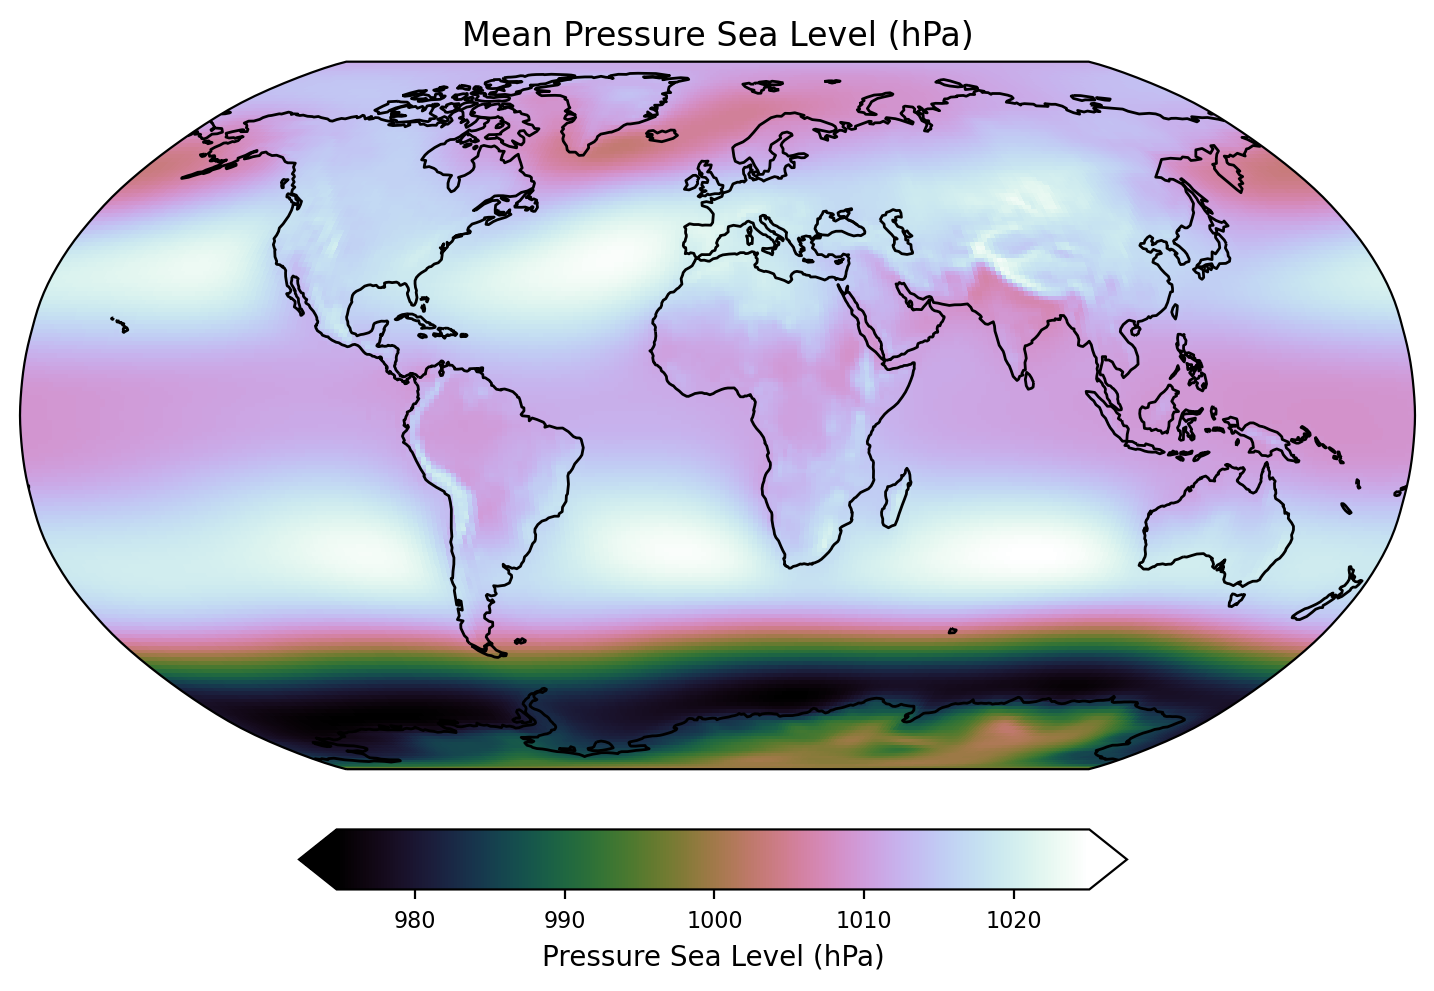

In [73]:
# Set a global map with chosen projection and plot the raster data

# Note on pcolormesh
# pcolormesh fills the grid cells / pixels identified by either grid edges or grid centroids
# Be careful of the way your raster data is organized

# https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.pcolormesh.html


fig = plt.figure(figsize=(9,6))  # x,y(inches)

ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.set_title('Mean Pressure Sea Level (hPa)')

mm = ax.pcolormesh(psl_mean.columns, # longitude
                   psl_mean.index, # latitude
                   psl_mean, # data
                   shading='auto', \
                   transform=ccrs.PlateCarree(),
                   cmap=mpl.cm.cubehelix )

# more color palettes here:
#   https://matplotlib.org/3.1.3/tutorials/colors/colormaps.html

ax.coastlines()

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46, 0.05]) #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('Pressure Sea Level (hPa)') #($\mu g$ $m^{-3}$)
cbar.ax.tick_params(labelsize=8)

plt.show()
plt.close()

Text(0.5, 1.0, 'Sea Level Pressure (Pa) from 2015 to 2050')

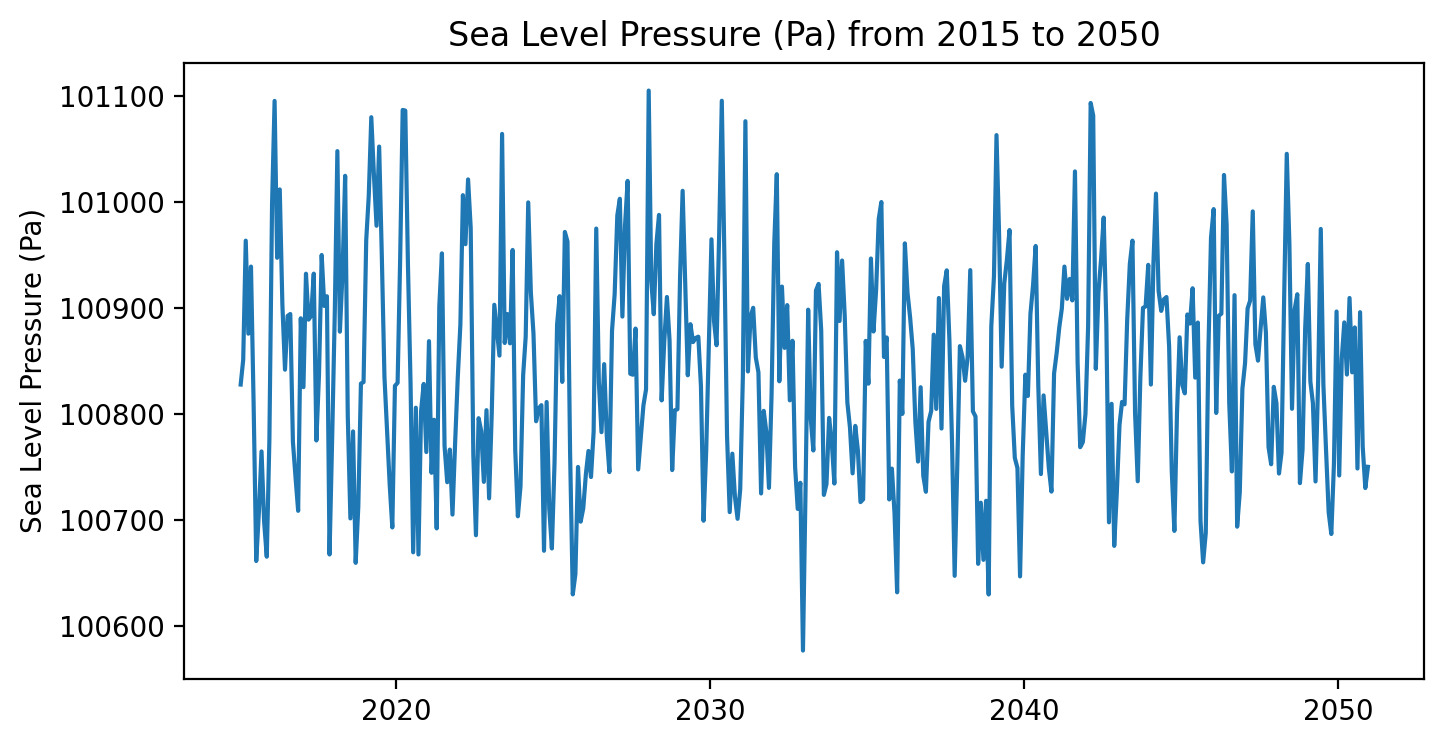

In [13]:
# Plot the mean values of the scenario over longitude and latitude
model.mean(['lat', 'lon']).psl.plot()
plt.xlabel('Year')
plt.ylabel('Sea Level Pressure (Pa)')
plt.title('Sea Level Pressure (Pa) from 2015 to 2050')

Text(0.5, 1.0, 'Sea Level Pressure (Pa) from 2015 to 2050')

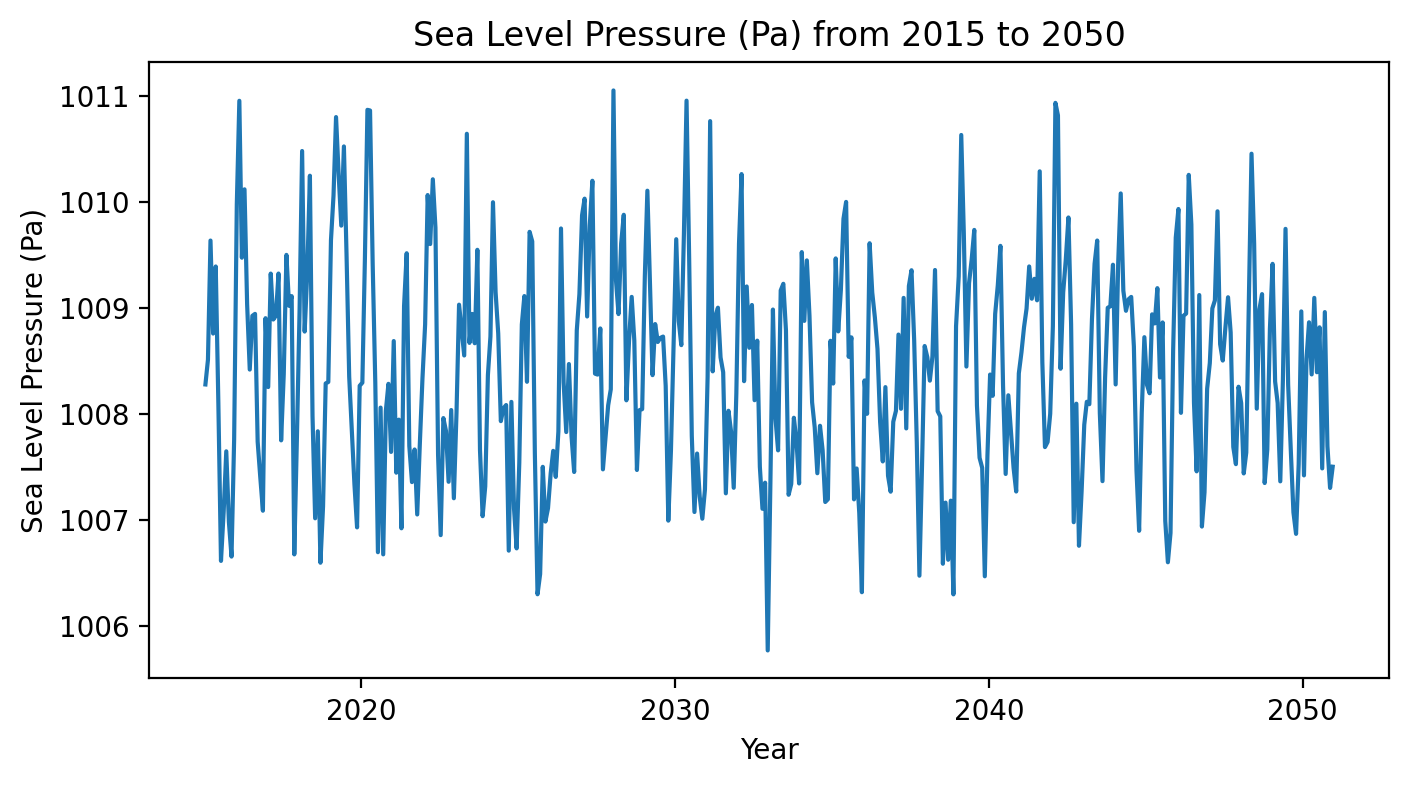

In [22]:
# Plot the mean values of the scenario over longitude and latitude
model.mean(['lat', 'lon']).psl_hpa.plot()
plt.xlabel('Year')
plt.ylabel('Sea Level Pressure (Pa)')
plt.title('Sea Level Pressure (Pa) from 2015 to 2050')

Text(0.5, 1.0, 'Sea Level Pressure (Pa) from 2015 to 2050 per Emisphere')

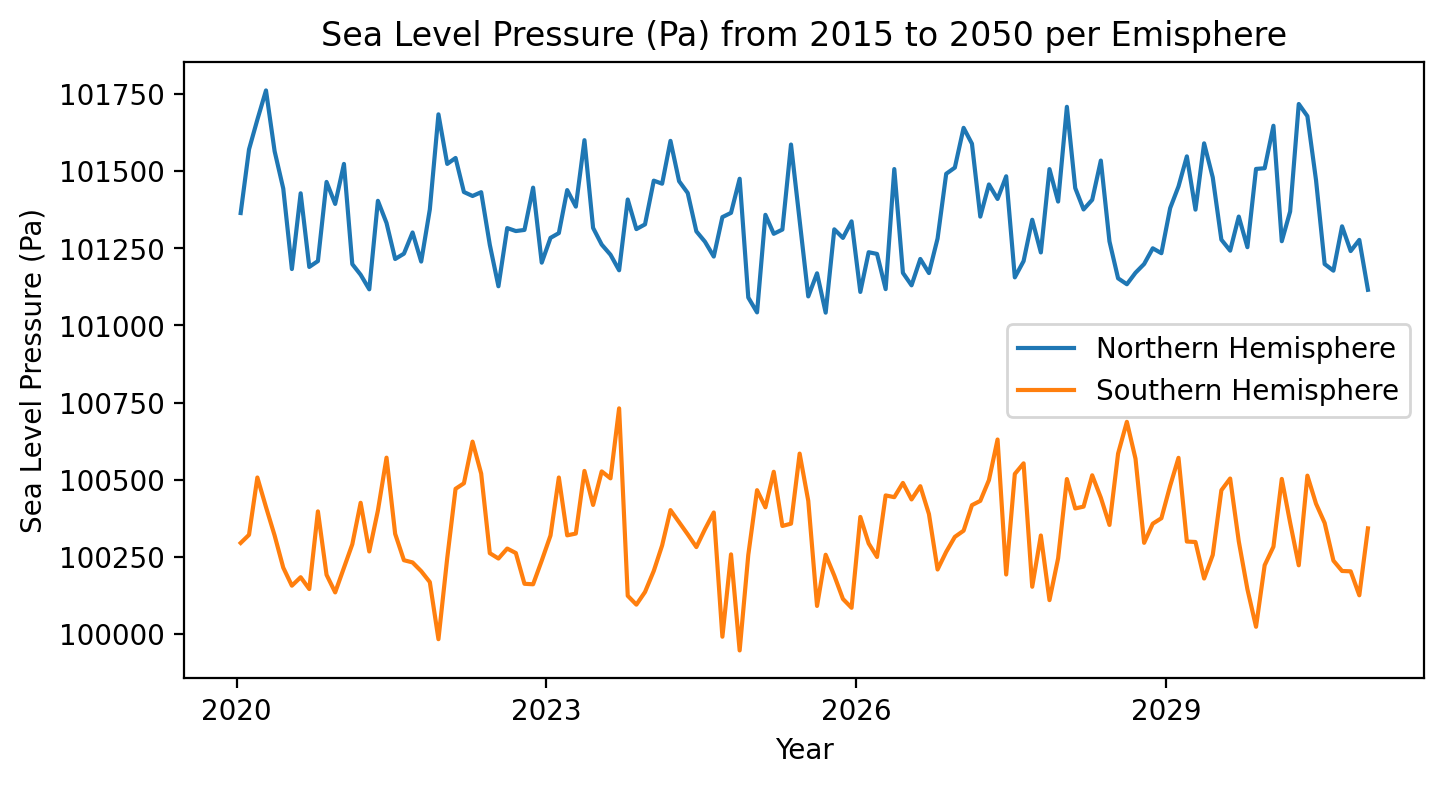

In [28]:
# Plot the mean values of the scenario over longitude and latitude (separating the emispheres)
model.where(model.lat > 0).sel({'time': slice('2020', '2030')}).mean(['lat', 'lon']).psl.plot(label='Northern Hemisphere')
model.where(model.lat < 0).sel({'time': slice('2020', '2030')}).mean(['lat', 'lon']).psl.plot(label='Southern Hemisphere')
plt.xlabel('Year')
plt.ylabel('Sea Level Pressure (Pa)')
plt.legend()
plt.title('Sea Level Pressure (Pa) from 2015 to 2050 per Emisphere')

Text(0.5, 1.0, 'Sea Level Pressure (Pa) from 2015 to 2050 per Emisphere')

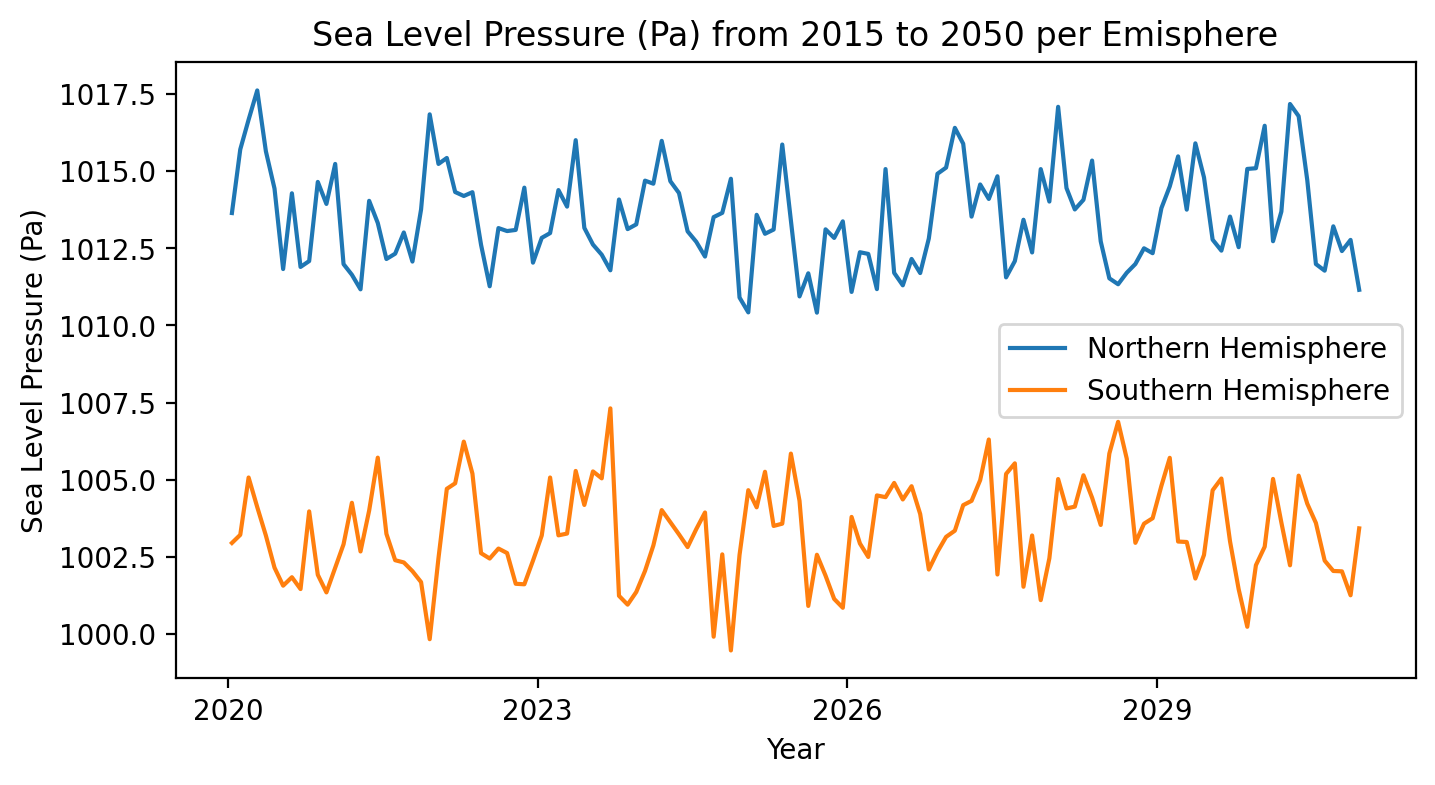

In [23]:
# Plot the mean values of the scenario over longitude and latitude (separating the emispheres)
model.where(model.lat > 0).sel({'time': slice('2020', '2030')}).mean(['lat', 'lon']).psl_hpa.plot(label='Northern Hemisphere')
model.where(model.lat < 0).sel({'time': slice('2020', '2030')}).mean(['lat', 'lon']).psl_hpa.plot(label='Southern Hemisphere')
plt.xlabel('Year')
plt.ylabel('Sea Level Pressure (Pa)')
plt.legend()
plt.title('Sea Level Pressure (Pa) from 2015 to 2050 per Emisphere')

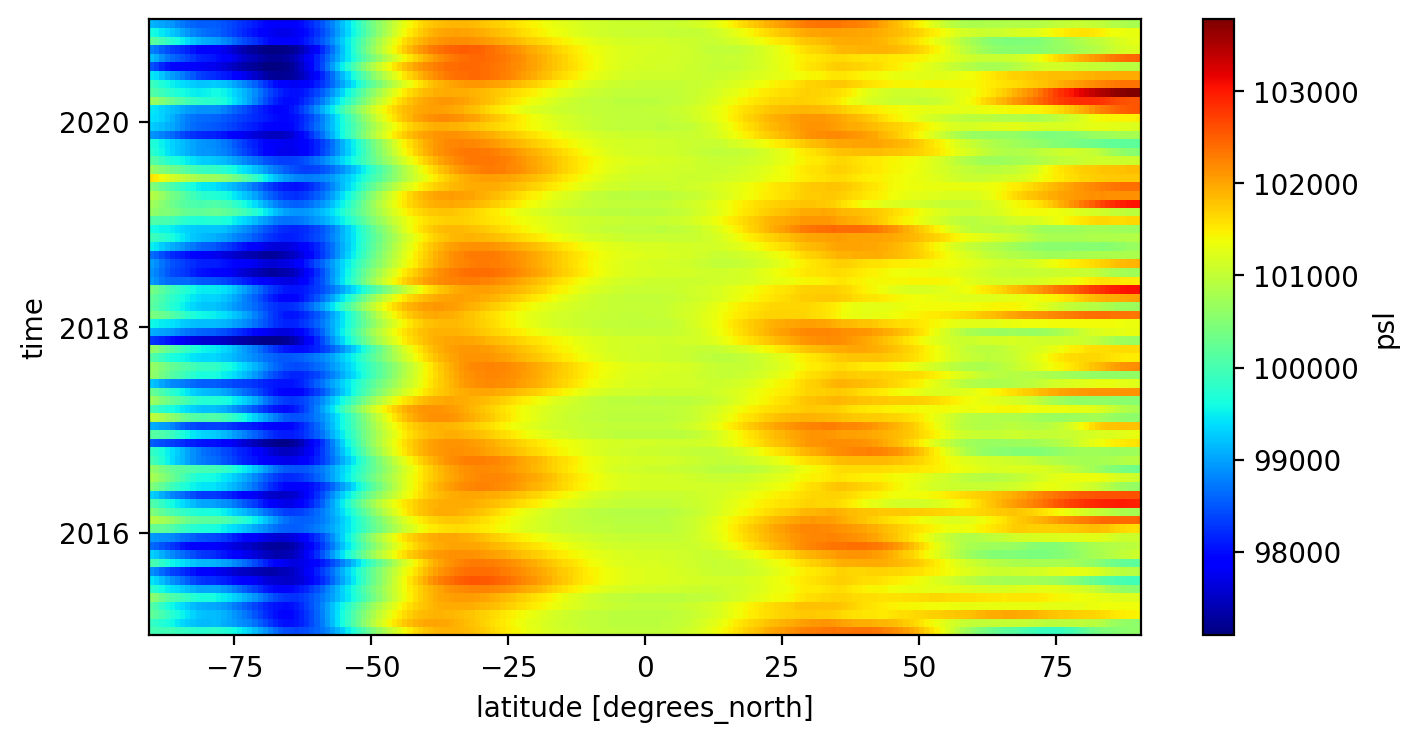

In [29]:
# Plot the mean values of the scenario over longitude
model.sel({'time': slice('2015', '2020')}).psl.mean(dim='lon').plot(cmap='jet')

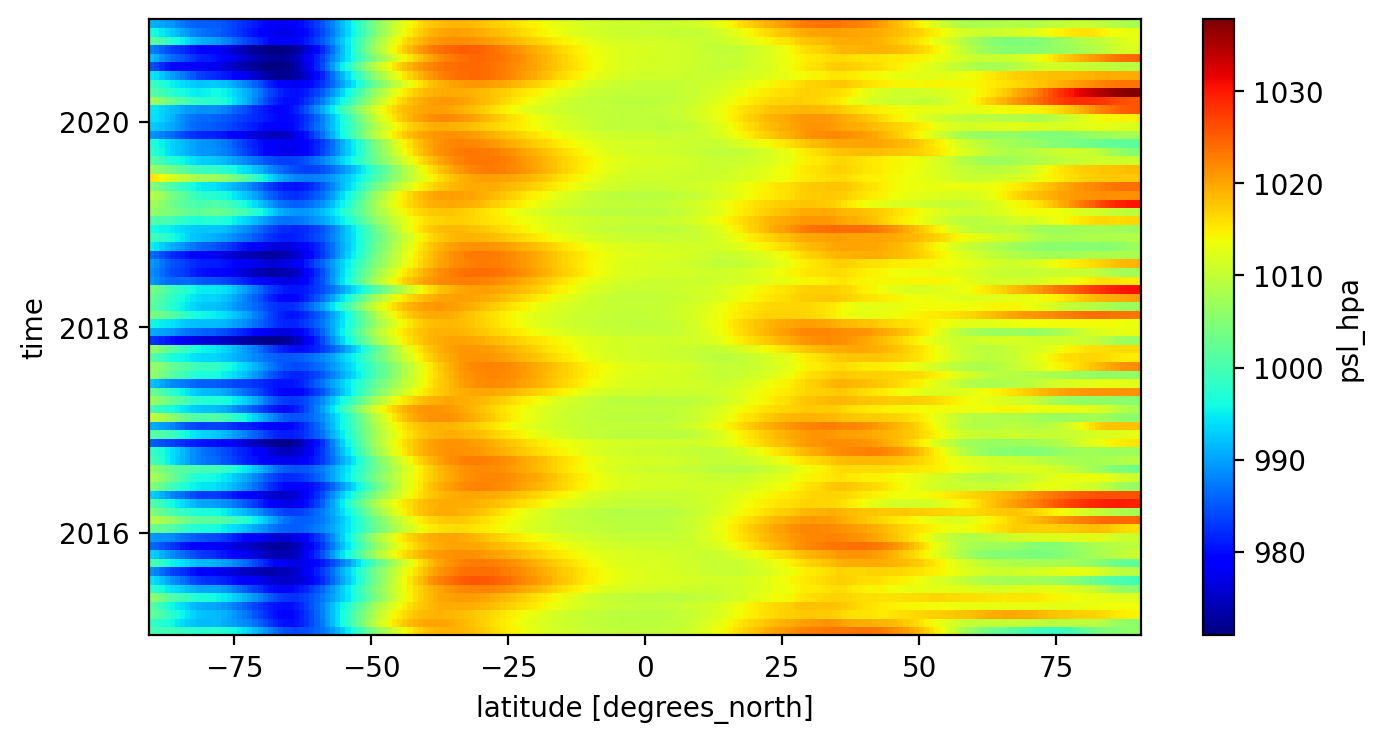

In [31]:
model.sel({'time': slice('2015', '2020')}).psl_hpa.mean(dim='lon').plot(cmap='jet')

In [43]:
# Compute the average yearly precipitations and the differences between the two scenarios
a = float(model.psl.mean(['time', 'lat', 'lon']) * 365)
b = float(model.psl_hpa.mean(['time', 'lat', 'lon']) * 365)

print('Annual mean sea level pressure of the scenario:      ', round(a, 3))
print('Annual mean sea level pressure (hPa) of the scenario:', round(b, 3))


Annual mean sea level pressure of the scenario:       36807569.531
Annual mean sea level pressure (hPa) of the scenario: 368075.588


### MSLP

### CESM2

## Spatial Aggregation: Regridding

## Temporal Aggregation

## Statistical Analysis